# 4. Implementation of Demand Forecasting in Python
### 4.1. Data
In this exercise, we are going to use the <a href = "https://www.kaggle.com/competitions/demand-forecasting-kernels-only">retail store data</a> available on Kaggle. This data set has 5 years of store-item sales data for 50 different items at 10 different stores (i.e., 5 years of data for 500 item-stores).

### 4.2. Preparation
#### 4.2.1. Check the version of Python and make sure Prophet is working

In [1]:
# Check the version of Python
!python --version

# Make sure Prophet is working - import Prophet
from prophet import Prophet

Python 3.7.13


#### 4.2.2. Import other necessary packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### 4.2.3. Import the data set and explore it

In [4]:
# Import the train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Concatenate them
df = pd.concat([train, test])

# View the first 5 entries
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


The above shows that we have date, store and item identifiers, and sales amounts.

In [5]:
# Describe the data frame
df.describe()

,store,item,sales,id
count,958000.000000,958000.000000,913000.000000,45000.000000
mean,5.500000,25.500000,52.250287,22499.500000
std,2.872283,14.430877,28.801144,12990.525394
min,1.000000,1.000000,0.000000,0.000000
25%,3.000000,13.000000,30.000000,11249.750000
50%,5.500000,25.500000,47.000000,22499.500000
75%,8.000000,38.000000,70.000000,33749.250000
max,10.000000,50.000000,231.000000,44999.000000


Several observations:
- The values in the store column range from 1-10 (i.e., we have 10 stores). 
- Similarly, the item values range from 1-50 (i.e., we have 50 items).
- We have some missing sales values.

In [6]:
# Number of missing values
df.isnull().sum()

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

#### 4.2.4. Data wrangling - Address the missing value issue
Let's examine whether there are any systematic patterns across missing values. We will start by examining differences across years.

In [7]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year from date
df['year'] = df['date'].dt.year

# Count missing values for each year
df['sales'].isnull().groupby([df['year']]).sum()

year
2013        0
2014        0
2015        0
2016        0
2017        0
2018    45000
Name: sales, dtype: int64

Bingo! All the missing values are in 2018. Let's count how many non-missing values are in 2018.

In [8]:
# Count non missing sales in 2018
df[df.year == 2018]['sales'].notnull().sum()

0

This confirms that all 2018 observations do not have sales information. Let's completely drop 2018 obs.

In [9]:
# Drop 2018 observations
df = df[df.year != 2018]

### 4.3. Exploratory Data Analysis (EDA) - Identify trends and seasonality
#### 4.3.1. Identify trends - Sales in aggregate and by store

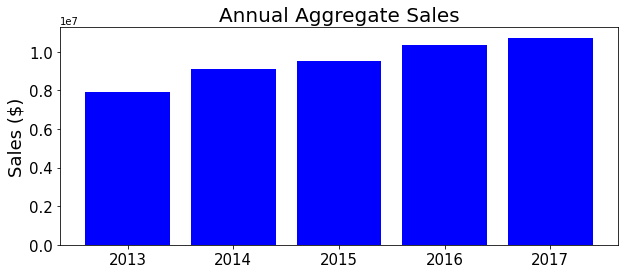

In [10]:
# Compute aggregate sales for each year
df_yearly = df.groupby(['year'], as_index=False).sum()

# Plot aggregate sales
plt.figure(figsize=(10,4))
plt.bar('year', 
        'sales', 
        data=df_yearly,
       color='blue')
plt.ylabel("Sales ($)", fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Annual Aggregate Sales', fontsize = 20)
plt.show()

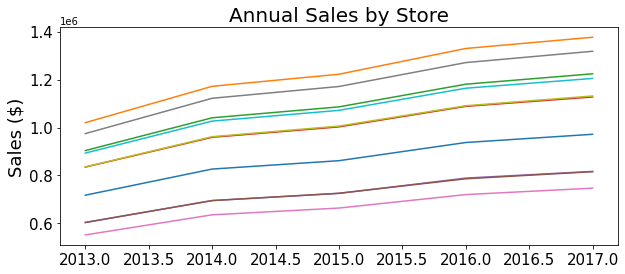

In [11]:
# Compute annual sales by store
df_yearly_store = pd.DataFrame(df.groupby(['year', 'store']).sum()['sales']).unstack()

# Plot it
plt.figure(figsize=(10,4))
plt.plot(df_yearly_store)
plt.ylabel("Sales ($)", fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Annual Sales by Store', fontsize = 20)
plt.show()

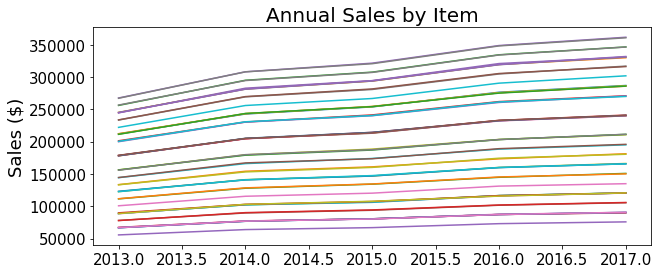

In [12]:
# Compute annual sales by store
df_yearly_item = pd.DataFrame(df.groupby(['year', 'item']).sum()['sales']).unstack()

# Plot it
plt.figure(figsize=(10,4))
plt.plot(df_yearly_item)
plt.ylabel("Sales ($)", fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Annual Sales by Item', fontsize = 20)
plt.show()

Clearly, all store sales and items are trending upwards. We'll incorporate this trend in our time-series models.

#### 4.3.2. Identify seasonality - Daily sales by store and by item

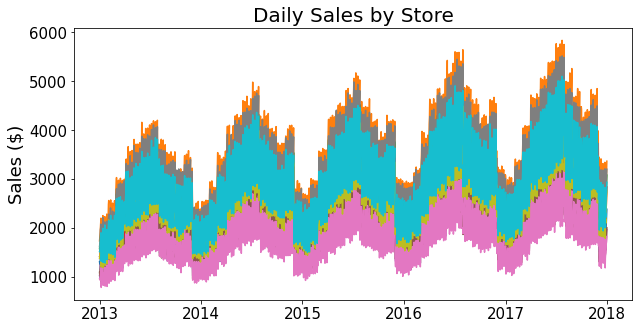

In [13]:
# Aggregate sales by store and date
df_daily_store = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()

# Plot daily sales by store
plt.figure(figsize=(10,5))
plt.plot(df_daily_store)
plt.title('Daily Sales by Store', fontsize = 20)
plt.ylabel("Sales ($)", fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

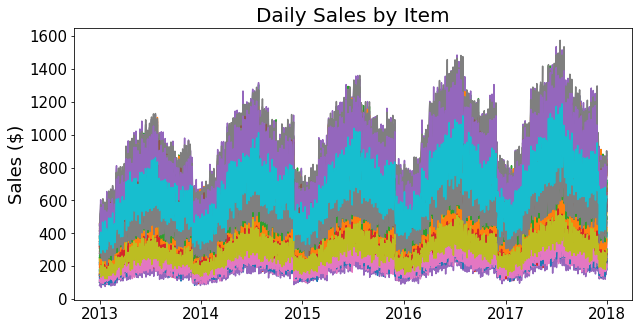

In [14]:
# Aggregate sales by store and date
df_daily_item = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()

# Plot daily sales by store
plt.figure(figsize=(10,5))
plt.plot(df_daily_item)
plt.title('Daily Sales by Item', fontsize = 20)
plt.ylabel("Sales ($)", fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Clearly, there is weekly seasonality. We will have to incorporate that into our models.

### 4.4. Prophet - Forecast One Product
Before we build 50 store x 10 item models in PySpark, let's build a time-series Prophet model for store 1, item 1.

#### 4.4.1. Prepare and fit the model
In our Prophet model, we are going to include a linear trend as well as weekly and annual seasonality.

In [15]:
# Store 1 item 1 data
s1i1 = df[(df.item==1)&(df.store==1)]

# Select columns
s1i1 = s1i1[["date", "sales"]]

# Prophet wants us to name columns as shown below
s1i1.columns = ["ds", "y"]

# instantiate the model and set parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

# fit the model to historical data
model.fit(s1i1);

#### 4.4.2. Evaluation - In-sample prediction
To evaluate the model, we are going to predict the time series in the last 3 months of the sample and compare it with the actual value. We will first visually inspect by plotting the actual and predicted values. Then, we will evaluate using a metric called Symmetric Mean Absolute Percentage Error.

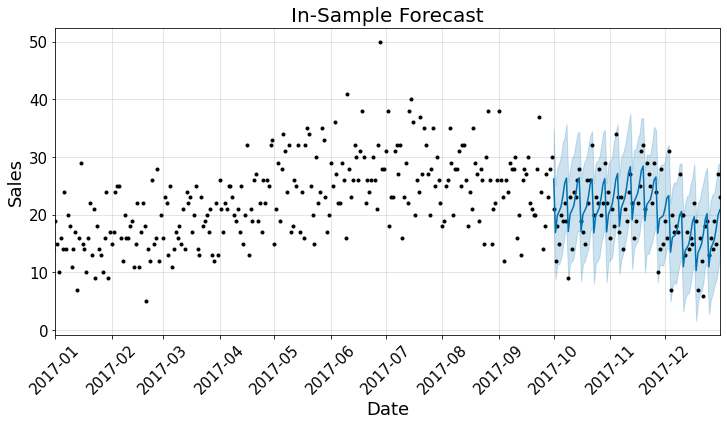

In [17]:
# Import library
import datetime

# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2017-10-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("In-Sample Forecast", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Sales", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2017-01-01', '2017-12-31'])) 
plt.show();

Based on the plot, our in-sample prediction isn't too bad but we cannot say it is doing fantastic. In a later post, we will try to see if CNN, LSTM, or Seasonal ARIMA models perform better.

Next, we will evaluate the model using popular evaluation metrics, MAPE and SMAPE. MAPE stands for Mean Absolute Percentage Error.

<img src ="https://github.com/youngdataspace/Time-Series-Forecasting-in-Spark/blob/main/MAPE3.JPG?raw=true">

Y refers to actual values and Y hat refers to predicted values. As the equation suggests, MAPE is the proportion of the MAPE is the average absolute forecast error as a percentage of actual values. Lower values indicate a better model.

One disadvantage of MAPE is that it puts a heavier penalty on negative errors. To overcome this, we can use SMAPE, which only ranges from 0 to 200%. The equation is shown below.

<img src ="https://github.com/youngdataspace/Time-Series-Forecasting-in-Spark/blob/main/SMAPE.JPG?raw=true">

<a href ="https://analyticsindiamag.com/a-guide-to-different-evaluation-metrics-for-time-series-forecasting-models/">This post</a> provides a good summary of popular evaluation metrics and <a href ="https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac">this post</a> nicely compares MAPE and SMAPE.

In [18]:
# SMAPE function
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ 
                     (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

# Create a data frame of prediction and actual values
evaluation = pd.merge(
    # Prediction
    prediction[["ds", "yhat"]], 
    # Actual
    s1i1[["ds", "y"]], 
    # Inner join on date
    how='inner', on='ds')

# MAPE and SMAPE
smape_kun(evaluation['y'],evaluation['yhat'])

MAPE: 22.15 % 
SMAPE: 19.79 %


#### 4.4.3. Out-of-sample prediction

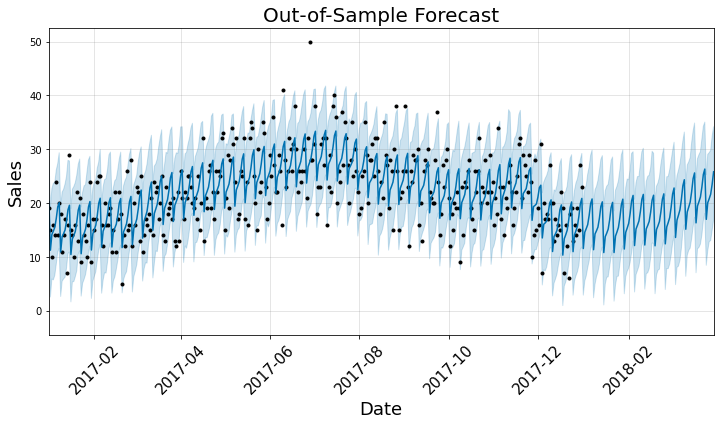

In [19]:
# Create a data frame that lists 90 dates starting from Jan 1 2018
future = model.make_future_dataframe(
    periods=90,
    freq='d',
    include_history=True)

# Out of sample prediction
future = model.predict(future)

# Plot
fig = model.plot(future, figsize=(10,5))
ax = fig.gca()
ax.set_title("Out-of-Sample Forecast", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Sales", size=18)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2017-01-01', '2018-03-31'])) 
plt.show();

### 4.8. Export the data set for forecasting multiple models in parallel with PySpark
Rather than continuing the analysis locally, we will export the data set and upload it to Google Drive. This way, we can continue with the PySpark analysis in Google Colab. I recommend you do the same at least because setting up PySpark is much easier in Google Colab.

In [21]:
# Select necessary columns
df_export = df[['date', 'store', 'item', 'sales']]

# Rename columns - Following Prophet requirements
df_export.columns = ['ds', 'store', 'item', 'y']

# Export to csv
df_export.to_csv('store_sales.csv', index=False)